In [2]:
import sys
if "/Users/raymond/code/FinalProject563" not in sys.path:
    sys.path.append("/Users/raymond/code/FinalProject563")
import torch
import pickle
import glob
import matplotlib.pyplot as plt
import random
import numpy as np
import pandas
import time
import os

import connect_four
import mcts
import connect_net
import connect_plot
import evaluation
import utils
import runner
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [3]:
os.chdir("/Users/raymond/code/FinalProject563")
trial = "blank01"
iteration = 1
training_folder = utils.get_training_folder(trial=trial, iteration=iteration)
training_path = runner.get_model_path(folder=training_folder, iteration=iteration)
nnet1 = connect_net.load_model(path=training_path, log=False)
iteration = 51
training_folder = utils.get_training_folder(trial=trial, iteration=iteration)
training_path = runner.get_model_path(folder=training_folder, iteration=iteration)
nnet51 = connect_net.load_model(path=training_path, log=False)
# networks = {}
# for i in range(1, 64):
#     iteration = i
#     training_folder = utils.get_training_folder(trial=trial, iteration=iteration)
#     training_path = runner.get_model_path(folder=training_folder, iteration=iteration)
#     nnet = connect_net.load_model(path=training_path, log=False)
#     networks[i] = nnet
# nnetp = connect_net.load_model(path="models/pretrain01.model", log=False)
# networks["p"] = nnetp
# print(len(networks))

In [5]:
# strategy1 = evaluation.NetworkStrategy(nnet=nnet63, c=1/16, eps=1e-6, num_mcts_sims=32, random_moves=4)
# strategy2 = evaluation.NetworkStrategy(nnet=nnet63, c=1/8, eps=1e-6, num_mcts_sims=32, random_moves=4)
# strategy3 = evaluation.NetworkStrategy(nnet=nnet63, c=1/4, num_mcts_sims=32, random_moves=4)
# strategy4 = evaluation.NetworkStrategy(nnet=nnet63, c=1/2, num_mcts_sims=32, random_moves=4)
# strategy5 = evaluation.NetworkStrategy(nnet=nnet63, c=1, num_mcts_sims=32, random_moves=4)
# strategy6 = evaluation.NetworkStrategy(nnet=nnet63, c=2, eps=1e-6, num_mcts_sims=32, random_moves=4)
# strategy7 = evaluation.NetworkStrategy(nnet=nnet63, c=4, eps=1e-6, num_mcts_sims=32, random_moves=4)

# strategy1 = evaluation.NetworkStrategy(nnet=nnet63, c=1, num_mcts_sims=4, random_moves=4)
# strategy2 = evaluation.NetworkStrategy(nnet=nnet63, c=1, num_mcts_sims=8, random_moves=4)
# strategy3 = evaluation.NetworkStrategy(nnet=nnet63, c=1, num_mcts_sims=16, random_moves=4)
# strategy4 = evaluation.NetworkStrategy(nnet=nnet63, c=1, num_mcts_sims=32, random_moves=4)
# strategy5 = evaluation.NetworkStrategy(nnet=nnet63, c=1, num_mcts_sims=64, random_moves=4)
# strategy6 = evaluation.NetworkStrategy(nnet=nnet63, c=1, num_mcts_sims=128, random_moves=4)

strategy1 = evaluation.NetworkStrategy(nnet=nnet1, c=1, num_mcts_sims=128, random_moves=4)
strategy2 = evaluation.NetworkStrategy(nnet=nnet51, c=1, num_mcts_sims=128, random_moves=4)

networks = {
    1: strategy1,
    2: strategy2,
#     3: strategy3,
#     4: strategy4,
#     5: strategy5,
#     6: strategy6,
#     7: strategy7,
}

In [8]:
scores = {k: 1600 for k in networks.keys()}
num_mcts_sims = 32
k = 32
list_df = []

In [9]:
for g in range(0, 100):
    if g % 5 == 0:
        print(g)
    sorted_players = sorted(scores.items(), key=lambda x: x[1])
    pairs = []
    for i in range(len(sorted_players)//2):
        pair = tuple(sorted_players[2*i:2*i+2])
        pairs.append(pair)
    for (p1, p1_rating), (p2, p2_rating) in pairs:
        result = evaluation.competition_game(player1=networks[p1], player2=networks[p2], log_games=False)
        R1 = 10**(p1_rating / 400)
        R2 = 10**(p2_rating / 400)
        Rtotal = R1 + R2
        e1 = R1 / Rtotal
        e2 = R2 / Rtotal
        if result[0] == "player1":
            s1, s2 = 1, 0
        elif result[0] == "player2":
            s1, s2 = 0, 1
        else:
            s1, s2 = 0.5, 0.5
        scores[p1] = p1_rating + k * (s1 - e1)
        scores[p2] = p2_rating + k * (s2 - e2)
    df_tmp = pandas.DataFrame(list(scores.items()), columns=["Player", "ELO"])
    df_tmp["iteration"] = g
    list_df.append(df_tmp)

0
5
10
15
20
25
30
35
40
45
50
55
60
65
70
75
80
85
90
95


<AxesSubplot:xlabel='iteration'>

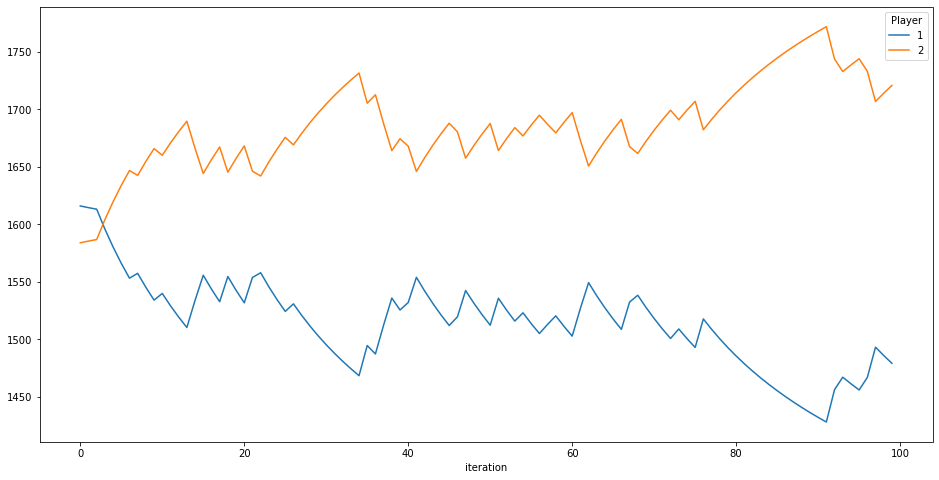

In [10]:
df_all = pandas.concat(list_df)
df_all.pivot("iteration", "Player", "ELO").plot(figsize=(16, 8))

In [13]:
df_scores = pandas.DataFrame(list(scores.items()), columns=["Player", "ELO"]).sort_values("ELO", ascending=False).head(10)
# df_scores["sims"] = 2 * 2**df_scores["Player"]
df_scores

,Player,ELO
1,2,1720.764093
0,1,1479.235907


<AxesSubplot:xlabel='Player'>

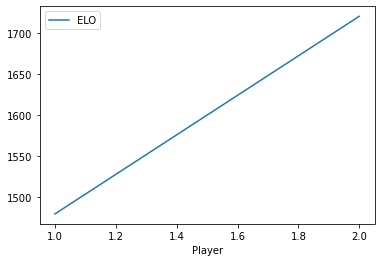

In [12]:
pandas.DataFrame(list(scores.items()), columns=["Player", "ELO"]).plot(x="Player", y="ELO")

In [22]:
results_folder = utils.get_results_folder(trial="blank01")
df_all = pandas.read_csv(os.path.join(results_folder, "all_scores.csv"))
df_fin = pandas.read_csv(os.path.join(results_folder, "fin_scores.csv"))

<AxesSubplot:xlabel='Player'>

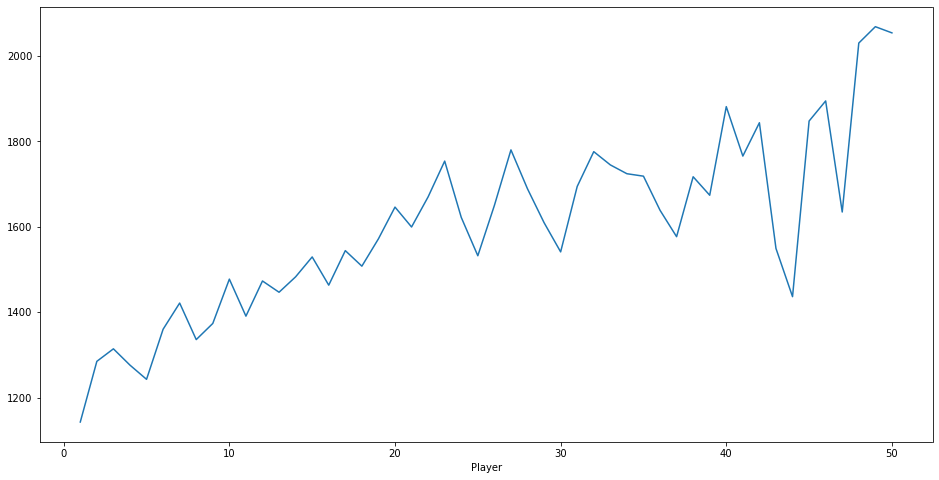

In [23]:
df_fin.set_index("Player")["ELO"].plot(figsize=(16, 8))

<AxesSubplot:xlabel='iteration'>

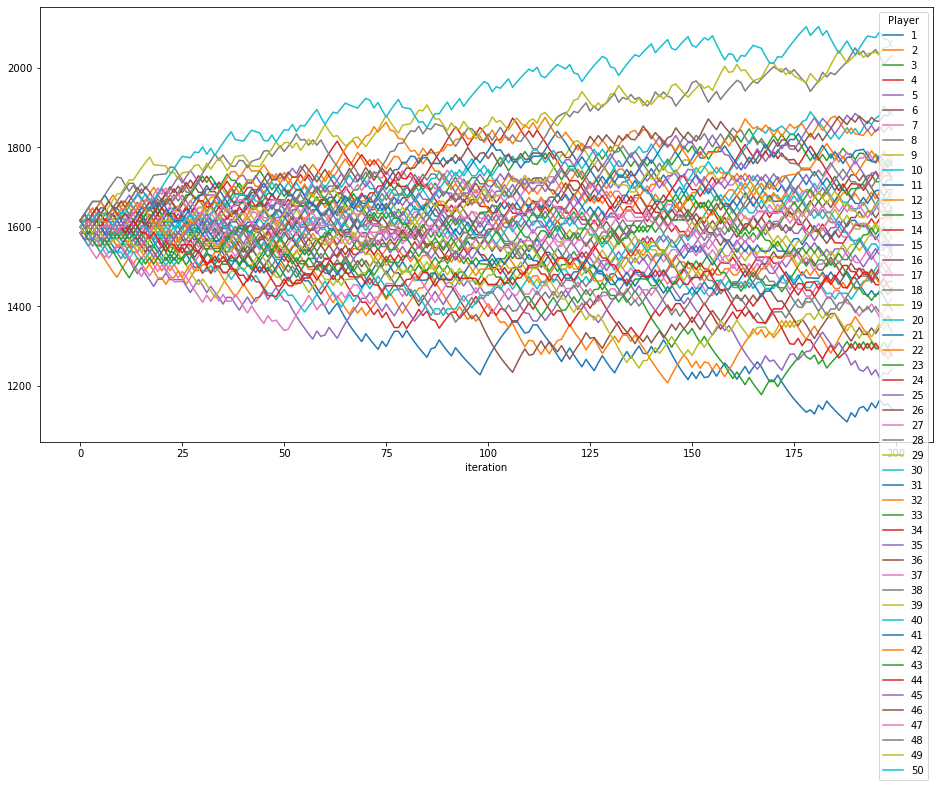

In [27]:
df_all.pivot("iteration", "Player", "ELO").plot(figsize=(16, 8))